In [23]:
import numpy as np
from numpy import pi
import pandas as pd
import random
import os
from qutip import *
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.optimizers import Adam
from collections import deque
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from keras import backend as K

%matplotlib inline

# DQL optimization of asymmetric Szilard engine
This program uses Deep Q-Learning, to find protocols which split the quantum wavefunction of an asymmetric Szilard engine in half.

# Define environment

In [2]:
class Szilard_env:
    
    def __init__(self):

        self.max_lvl = 4
        
        self.viewer = None
        self.action_space = np.array([-1024,-512,-256,-128,-64,-32,-16,-8,-4,-2,0
                                      ,2,4,8,16,32,64,128,256,512,1024])*10
        self.observation_space = np.array([0,0])
        
        self.max_alfa = 2000.0
        
        self.t_max = 5
        self.N_alfa = 50
        self.alfa_dt = self.t_max/self.N_alfa
        
        self.sigma1 = 0.05    # smaller gives more punishment for excitations
        self.sigma2 = 0.1
        
        self.best_protocol = [None]*self.N_alfa
        self.protocol = [None]*self.N_alfa
        self.best_reward = 0
        self.scores = []
        
        self.interp_energies = []
        self.interp_overlaps = []
        k = 0
        
        self.N_asymmetries = 6
        self.asymmetries = []
        
        for n in range (self.N_asymmetries):
            asymmetry = round(0.53 + 0.002*n,3)
            self.asymmetries.append(asymmetry)
            energy, overlap = self.interp_generator(asymmetry)
            self.interp_energies.append(energy)
            self.interp_overlaps.append(overlap)
        
        ## Here we can change the reward distribution to favour certain asymmetries
        
        #r_min  = 0.50
        #N_0 = -self.N_asymmetries/np.log(r_min)
        #x = np.array([n for n in range (self.N_asymmetries)])
        #self.reward_distribution = np.exp(-x/N_0)
        self.reward_distribution = np.ones(self.N_asymmetries)
            
    ## Interpolate data files to calculate eigenstates of the single-particle-box.    
    def interp_generator(self,a):
    
        max_lvl = 4 

        tab_alfa = np.loadtxt('/home/vegard/Split-wavefunction/data/alfa/alfa_a_' + "{:.3f}".format(a) + '.txt', delimiter = ',')        
        energies = np.loadtxt('/home/vegard/Split-wavefunction/data/energies/Energies_a_' + "{:.3f}".format(a) + '.txt', delimiter = ',')
        overlap = np.loadtxt('/home/vegard/Split-wavefunction/data/overlap/overlap_a_' + "{:.3f}".format(a)+ '.txt', delimiter = ',')

        overlap = np.reshape(overlap, [max_lvl,max_lvl,5001], order = 'F')

        interp_energy = [None]*max_lvl

        for n in range(max_lvl):
            f = interp1d(tab_alfa,energies[:,n], kind = 'cubic')
            interp_energy[n] = f

        interp_overlap = [[0] * max_lvl for i in range(max_lvl)]

        for n in range(max_lvl):
            for m in range(max_lvl):
                interp_overlap[n][m] = interp1d(tab_alfa,overlap[n,m,:], kind = 'cubic')

        return interp_energy, interp_overlap
    
    ## Interpolate the discrete protocol obtained from the agent at the end of each episode, and calculate the reward.
    def interp_reward(self, N_t):

        time_interp = np.array([ n*self.alfa_dt for n in range (self.N_alfa+1) ])
        
        alfa_interp = interp1d( time_interp,self.protocol, kind = 'cubic')
      
        time = np.linspace(0,self.t_max,N_t)
        alfa = alfa_interp(time)
        alfa = np.clip(alfa, 0, 5000)
    
        dt = time[1]-time[0]
        max_lvl = self.max_lvl
 
        E = []
        for t in range(N_t):
            E.append([self.interp_energy[n](alfa[t]) for n in range(max_lvl)])
        E = np.array(E)
        
        phi = []
        for t in range(N_t):
                integral = [np.trapz(x=time[0:t+1], y= E[0:t+1,n]) for n in range(max_lvl)]
                phi.append(integral)  
        phi = np.array(phi)   

        def interaction_int(n, alfa_in, f = []):
            test = sum([self.interp_overlap[n][m](abs(alfa_in))*np.exp(1j*(phi[t,n] - phi[t,m]) )*f[m] for m in range(max_lvl) if m != n ])*dalfa
            return test

        C = np.array([ 0 for n in range(max_lvl) ])
        C[0] = 1
        C_new = np.array( [ 0 for n in range(max_lvl) ])
        C_t = []
        C_t.append(C)

        for t in range(N_t -1):
            
            dalfa = (alfa[t+1] - alfa[t])/dt

            k1 = np.array([dt*interaction_int(n, alfa[t], C ) for n in range(max_lvl)])
            k2 = np.array([dt*interaction_int(n, alfa[t]+ dalfa*dt/2, C + k1/2 ) for n in range(max_lvl)])
            k3 = np.array([dt*interaction_int(n, alfa[t]+ dalfa*dt/2, C + k2/2 ) for n in range(max_lvl)])
            k4 = np.array([dt*interaction_int(n, alfa[t]+ dalfa*dt, C + k3) for n in range(max_lvl)])

            C_new = C + (k1 + 2*k2 + 2*k3 + k4)/6

            C = C_new

            C_t.append(C)

        c1 = abs(C[0])**2
        c2 = abs(C[1])**2
        
        reward = np.exp( -((c1 + c2 - 1))**2/self.sigma1 - ((c1 - c2))**2/self.sigma2 )
        
        #reward = - ((c1 + c2 - 1))**2/self.sigma1 - ((c1 - c2))**2/self.sigma2 

        #leakage = sum( abs(C[n])**2 for n in range(2,max_lvl) )
        #reward = np.exp( -((c1-0.5)**2 + (c2-0.5)**2)/(sigma))
        
        #print("Normalization_int: {}" .format(sum(abs(C)**2)))
        #print(abs(C)**2)
        #plt.plot(alfa(time),abs(np.array(C_t))**2)
        #plt.plot(time,abs(alfa(time)))
        
        return reward   

    ## Reset initial state after every episode     
    def reset(self):

        self.r = random.randrange(self.N_asymmetries)
        self.interp_energy = self.interp_energies[self.r]
        self.interp_overlap = self.interp_overlaps[self.r]
        
        self.time = 0.0
        self.alfa = 0.0
        self.steps = 0
        
        self.protocol = []
        self.protocol.append(0)
        self.action_sequence = []

        self.cum_reward = 0.0
                
        self.state =  [self.alfa/self.max_alfa] + [self.time/self.t_max]
        
        return np.array(self.state)       
    
    ## Take one step, and give reward as feedback.
    def step(self, action): 
        
        self.action_sequence.append(action)
        self.time += self.alfa_dt
        self.dalfa = self.action_space[action]
                
        self.new_alfa = self.alfa + self.dalfa*self.alfa_dt
        
        if self.new_alfa < 0.0:
            reward = -10
        elif self.new_alfa > self.max_alfa:
            reward = -10
        else:
            reward = 0

        self.new_alfa = np.clip(self.new_alfa, 0.0, self.max_alfa)
        
        self.steps += 1     
        self.protocol.append(self.new_alfa)
 
    
        self.alfa = self.new_alfa

        next_state = [self.alfa/self.max_alfa] + [self.time/self.t_max]

        
        if self.steps == self.N_alfa:
            
            N_t = 1000
            reward += 100*self.interp_reward(N_t)*self.reward_distribution[self.r]            
            done = True            
            #if  reward > self.best_reward:
             #   self.best_protocol = self.protocol
             #   self.best_reward = reward
                #print('REWARD: {}'.format(reward))
        else:
            done = False
         
        
        self.cum_reward += reward
        
        if done == True:
            
            self.scores.append(self.cum_reward)
        
        return np.array(next_state), reward, done, {}

# Define agent

In [3]:

class DQNAgent:
    
    def __init__(self, state_size, action_size):
        
        self.state_size = state_size
        self.action_size = action_size
        
        self.memory = deque(maxlen = 50000)
        
        self.gamma = 1.0
        
        self.epsilon = 1.0
        self.epsilon_decay = 0.99995
        self.epsilon_min = 0.01
        
        self.learning_rate = 0.001        
        
        self.model = self._build_model()
        self.target_model = self._build_model()
        
    def _build_model(self):
        
        model = Sequential()
        
        model.add(Dense(24, input_dim = self.state_size, activation = 'relu'))
        
        model.add(Dense(48, activation = 'relu'))
        
        model.add(Dense(24, activation = 'relu'))

        model.add(Dense(self.action_size, activation = 'linear'))
        
        model.compile(loss='mse', optimizer = Adam(lr = self.learning_rate))
        
        return model
    
    
    def remember(self, state, action, reward, next_state, done):
        
        self.memory.append((state, action, reward, next_state, done))
        
    def act(self,state):
        
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])
    
    def replay(self, batch_size):
        
        
        minibatch = random.sample(self.memory, batch_size)
        

        for state, action, reward, next_state, done in minibatch:
            
            target = self.target_model.predict(state)
            
            if done:
                target[0][action] = reward
                
            else:
                Q_future = max(self.target_model.predict(next_state)[0])
                target[0][action] = reward + Q_future*self.gamma
                
            self.model.fit(state, target, epochs = 1, verbose = 0)    
    
    def load(self, name):
        self.model.load_weights(name)
        
    def save(self,name):
        self.model.save_weights(name)
        
        
                

# Set Parameters

In [4]:
env = Szilard_env()
state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]
print('State size: {}'.format(state_size))
print('Action size: {}'.format(action_size))

batch_size = 32
n_episodes = 40000
tau = 1e-3

agent = DQNAgent(state_size, action_size)
agent.epsilon_decay = (0.05)**(1/n_episodes)
agent.memory = deque(maxlen = 200000)

score = [None]*n_episodes

output_dir = 'model_output/Model_6/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
print("Training on {} asymmetries in the range : {}".format(env.N_asymmetries,env.asymmetries))
print("Available actions: \n{}".format(env.action_space))
print("T_max = {}, Number of steps = {}, dt = {}".format(env.t_max, env.N_alfa, env.alfa_dt))
print("Hyperparameters: memorysize = {}, tau = {}, batch_size = {}".format(len(agent.memory),tau, batch_size))
print("Total number of experiences = {}".format(env.N_alfa*n_episodes))

State size: 2
Action size: 21
Training on 6 asymmetries in the range : [0.53, 0.532, 0.534, 0.536, 0.538, 0.54]
Available actions: 
[-10240  -5120  -2560  -1280   -640   -320   -160    -80    -40    -20
      0     20     40     80    160    320    640   1280   2560   5120
  10240]
T_max = 5, Number of steps = 50, dt = 0.1
Hyperparameters: memorysize = 0, tau = 0.001, batch_size = 32
Total number of experiences = 2000000


# Interact with environment

In [ ]:
done = False

for e in range(n_episodes):
    
    state = env.reset()
    state = np.reshape(state, [1,state_size])
    
    for t in range(1000):
        
        action = agent.act(state)
        
        next_state, reward, done, _ = env.step(action)
                
        next_state = np.reshape(next_state, [1,state_size])
        
        agent.remember(state, action, reward, next_state, done)
        
        state = next_state
        
        if done:
            print('episode: {}/{}, score: {:.3}, epsilon: {:.2}'.format(e,n_episodes, env.cum_reward, agent.epsilon))
            score[e] = env.cum_reward
            break
        
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)

            target_weights = np.array(agent.target_model.get_weights())
            current_weights = np.array(agent.model.get_weights())

            agent.target_model.set_weights(current_weights*tau + target_weights*(1-tau))
        
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon *= agent.epsilon_decay
    
    if e % 100 == 0:
        agent.save(output_dir + "weights_" + "{:04d}".format(e) + ".hdf5")
            
        
        
    

Training on 6 asymmetries in the range : [0.53, 0.532, 0.534, 0.536, 0.538, 0.54]
Available actions: 
[-10240  -5120  -2560  -1280   -640   -320   -160    -80    -40    -20
      0     20     40     80    160    320    640   1280   2560   5120
  10240]
T_max = 5, Number of steps = 50, dt = 0.1
Hyperparameters: memorysize = 200000, tau = 0.001, batch_size = 32
Total number of experiences = 2000000
Reward distribution: [1. 1. 1. 1. 1. 1.]


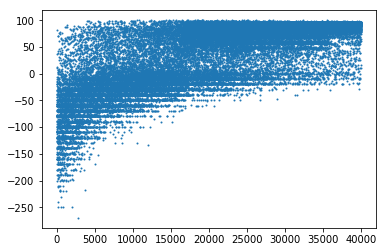

In [6]:
episodes = [n for n in range(len(score))]
plt.scatter(episodes,score, s = 1)
#plt.ylim([-1000,0])
print("Training on {} asymmetries in the range : {}".format(env.N_asymmetries,env.asymmetries))
print("Available actions: \n{}".format(env.action_space))
print("T_max = {}, Number of steps = {}, dt = {}".format(env.t_max, env.N_alfa, env.alfa_dt))
print("Hyperparameters: memorysize = {}, tau = {}, batch_size = {}".format(len(agent.memory),tau, batch_size))
print("Total number of experiences = {}".format(env.N_alfa*n_episodes))
print("Reward distribution: {}".format(np.around(env.reward_distribution,2)))

## Load earlier instances of the agent, and find its best solution

In [413]:
loaded_agent = DQNAgent(state_size, action_size)
loaded_agent.model.load_weights('model_output/Model_1/weights_10000.hdf5')

state = env.reset()
state = np.reshape(state, [1,state_size])
loaded_agent.epsilon = 0.0

for t in range(env.N_alfa):

    action = loaded_agent.act(state)

    next_state, reward, done, _ = env.step(action)

    next_state = np.reshape(next_state, [1,state_size])

    state = next_state

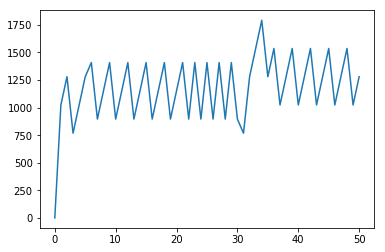

In [7]:
plt.plot(env.protocol)

In [17]:
state = env.reset()
state = np.reshape(state, [1,state_size])
agent.epsilon = 0.0

for t in range(env.N_alfa):

    action = agent.act(state)

    next_state, reward, done, _ = env.step(action)

    next_state = np.reshape(next_state, [1,state_size])

    state = next_state

# Testing on different asymmetries

0.53
0.532
0.534
0.536
0.538
0.54


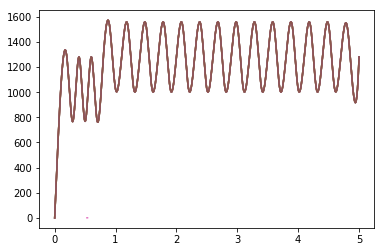

In [20]:
protocol = env.protocol

N = env.N_asymmetries
asymmetries = env.asymmetries

leakage = [0 for n in range (N)]
asymmetry = [0 for n in range (N)]
punishment = [0 for n in range (N)]
C_array = [0 for n in range (N)]

for n in range (N):
    print(asymmetries[n])
    interp_energy, interp_overlap = interp_generator(asymmetries[n])
    
    C_array[n],leakage[n], punishment[n] = interp_reward(0.05,1000,protocol)
  
plt.plot(asymmetries,punishment)

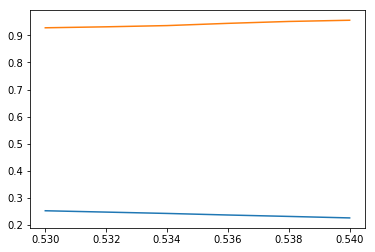

In [21]:
plt.plot(asymmetries,leakage)
plt.plot(asymmetries,punishment)

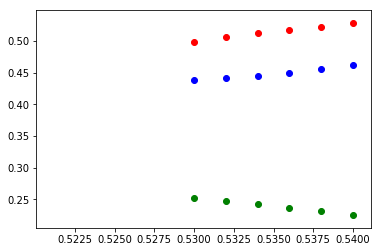

In [22]:
for n in range(N):
    
    plt.scatter(asymmetries[n],abs(C_array[n][0])**2, color = 'red')
    plt.scatter(asymmetries[n],abs(C_array[n][1])**2, color = 'blue')
    plt.scatter(asymmetries[n],sum(abs(C_array[n][2:])**2), color = 'green')



In [19]:
def interp_reward(sigma, N_t, protocol):

        time = np.array([ n*env.alfa_dt for n in range (env.N_alfa+1) ])
        alfa_interp = interp1d( time,protocol, kind = 'cubic')

        time = np.linspace(0,env.t_max,N_t)
        alfa = alfa_interp(time)
        alfa = np.clip(alfa,0,5000)
        dt = time[1]-time[0]
        max_lvl = env.max_lvl
 
        E = []
        for t in range(N_t):
            E.append([interp_energy[n](alfa[t]) for n in range(max_lvl)])
        E = np.array(E)
        
        phi = []
        for t in range(N_t):
                integral = [np.trapz(x=time[0:t+1], y= E[0:t+1,n]) for n in range(max_lvl)]
                phi.append(integral)  
        phi = np.array(phi)   

        def interaction_int(n, alfa_in, f = []):
            test = sum([interp_overlap[n][m](abs(alfa_in))*np.exp(1j*(phi[t,n] - phi[t,m]) )*f[m] for m in range(max_lvl) if m != n ])*dalfa
            return test

        C = np.array([ 0 for n in range(max_lvl) ])
        C[0] = 1
        C_new = np.array( [ 0 for n in range(max_lvl) ])
        C_t = []
        C_t.append(C)

        for t in range(N_t -1):
            
            dalfa = (alfa[t+1] - alfa[t])/dt

            k1 = np.array([dt*interaction_int(n, alfa[t], C ) for n in range(max_lvl)])
            k2 = np.array([dt*interaction_int(n, alfa[t]+ dalfa*dt/2, C + k1/2 ) for n in range(max_lvl)])
            k3 = np.array([dt*interaction_int(n, alfa[t]+ dalfa*dt/2, C + k2/2 ) for n in range(max_lvl)])
            k4 = np.array([dt*interaction_int(n, alfa[t]+ dalfa*dt, C + k3) for n in range(max_lvl)])

            C_new = C + (k1 + 2*k2 + 2*k3 + k4)/6

            C = C_new

            C_t.append(C)

        #C_t = np.array(C_t)

        c1 = abs(C[0])**2
        c2 = abs(C[1])**2

        leakage = sum( abs(C[n])**2 for n in range(2,max_lvl) )
        reward = np.exp( -((c1-0.5)**2 + (c2-0.5)**2)/(sigma))
        
        #print("Normalization_int: {}" .format(sum(abs(C)**2)))
        #print(abs(C)**2)
        #plt.plot(alfa(time),abs(np.array(C_t))**2)
        #plt.plot(time,abs(alfa(time)))
        plt.plot(time,alfa)
        return C, leakage, reward   

In [13]:
def interp_generator(a):
    
    max_lvl = 4 

    tab_alfa = np.loadtxt('/home/vegard/Split-wavefunction/data/alfa/alfa_a_' + "{:.3f}".format(a) + '.txt', delimiter = ',')        
    energies = np.loadtxt('/home/vegard/Split-wavefunction/data/energies/Energies_a_' + "{:.3f}".format(a) + '.txt', delimiter = ',')
    overlap = np.loadtxt('/home/vegard/Split-wavefunction/data/overlap/overlap_a_' + "{:.3f}".format(a)+ '.txt', delimiter = ',')

    overlap = np.reshape(overlap, [max_lvl,max_lvl,5001], order = 'F')


    interp_energy = [None]*max_lvl

    for n in range(max_lvl):
        f = interp1d(tab_alfa,energies[:,n], kind = 'cubic')
        interp_energy[n] = f

    interp_overlap = [[0] * max_lvl for i in range(max_lvl)]

    for n in range(max_lvl):
        for m in range(max_lvl):
            interp_overlap[n][m] = interp1d(tab_alfa,overlap[n,m,:], kind = 'cubic')
    
    return interp_energy, interp_overlap

# Plot Q function

In [30]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [131]:
loaded_agent = DQNAgent(state_size, action_size)
loaded_agent.epsilon = 0.0
loaded_agent.model.load_weights(output_dir+'weights_1000.hdf5')

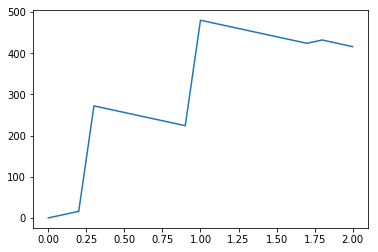

In [132]:
Q_protocol = []
Q_alfa = 0
Q_time = []

Q_protocol.append(0)
Q_time.append(0)

for t in range (env.N_alfa):
    
    time = (t+1)*env.alfa_dt
    
    state = np.array([Q_alfa/env.max_alfa,time/env.t_max])
    state = np.reshape(state, [1,state_size])
    max_arg = np.argmax(loaded_agent.model.predict(state)) 
    #print("action: {}".format(max_arg))
    Q_alfa += env.action_space[max_arg]*env.alfa_dt
    #print("suggest: {}".format(Q_alfa))
    Q_alfa = np.clip(Q_alfa,0,env.max_alfa)
    #print("actual: {}".format(Q_alfa))
    
    Q_time.append(time)
    Q_protocol.append(Q_alfa)

plt.plot(Q_time,Q_protocol)

In [133]:
t_max = env.t_max
max_alfa = env.max_alfa

N_a = 50
N_t = 50

Q_max = np.ndarray(shape=(N_t,N_a),buffer = np.zeros(N_t*N_a))
Q_max_arg = np.ndarray(shape=(N_t,N_a),buffer = np.zeros(N_t*N_a))

time = np.linspace(0,t_max,N_t)
alfa = np.linspace(0,max_alfa,N_a)

alfa_time = np.arange(0,env.t_max,env.alfa_dt)
max_protocol = alfa_time*env.action_space[-1]
max_protocol = np.clip(max_protocol, 0, env.max_alfa)

for t in range (N_t):
    
    for a in range(N_a):        
        
        state = np.array([alfa[a]/max_alfa,time[t]/t_max])
        state = np.reshape(state, [1,state_size])

        Q_max_arg[t,a] = np.argmax(loaded_agent.model.predict(state))
        Q_max[t,a] = np.max(loaded_agent.model.predict(state))



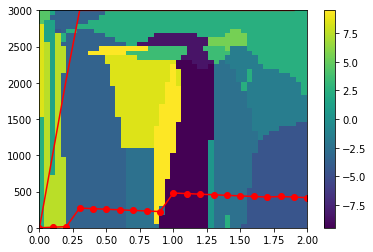

In [134]:
X,Y = np.meshgrid(time, alfa)

Z = Q_max_arg - len(env.action_space)/2

fig, ax = plt.subplots()


p = ax.pcolor(X, Y, Z)
cb = fig.colorbar(p)

plt.plot(alfa_time,max_protocol , color='red')
plt.plot(Q_time,Q_protocol, 'o-', color ='red')

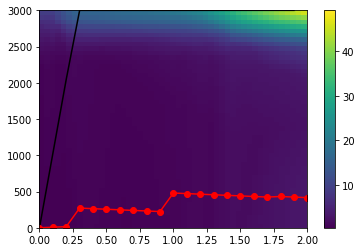

In [135]:
X,Y = np.meshgrid(time, alfa)

Z = Q_max

fig, ax = plt.subplots()

p = ax.pcolor(X, Y, Z, vmin=Z.min(), vmax=Z.max())
cb = fig.colorbar(p)

plt.plot(alfa_time,max_protocol , color='black')
plt.plot(Q_time,Q_protocol, 'o-', color ='red')